In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [141]:
df = pd.read_csv('Occupancy.csv')

df_reg = df
csv = np.genfromtxt("Occupancy.csv", delimiter=',')

df.head()
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.2720,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.2900,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.2300,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.1250,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.2000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...,...
20555,2015-02-18 09:15:00,20.8150,27.7175,429.750000,1505.250000,0.004213,1
20556,2015-02-18 09:16:00,20.8650,27.7450,423.500000,1514.500000,0.004230,1
20557,2015-02-18 09:16:59,20.8900,27.7450,423.500000,1521.500000,0.004237,1
20558,2015-02-18 09:17:59,20.8900,28.0225,418.750000,1632.000000,0.004279,1


       Temperature  hour  dayofweek  month  dayofyear
0          23.7000    14          0      2         33
1          23.7180    14          0      2         33
2          23.7300    14          0      2         33
3          23.7225    14          0      2         33
4          23.7540    14          0      2         33
...            ...   ...        ...    ...        ...
20555      20.8150     9          2      2         49
20556      20.8650     9          2      2         49
20557      20.8900     9          2      2         49
20558      20.8900     9          2      2         49
20559      21.0000     9          2      2         49

[20560 rows x 5 columns]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

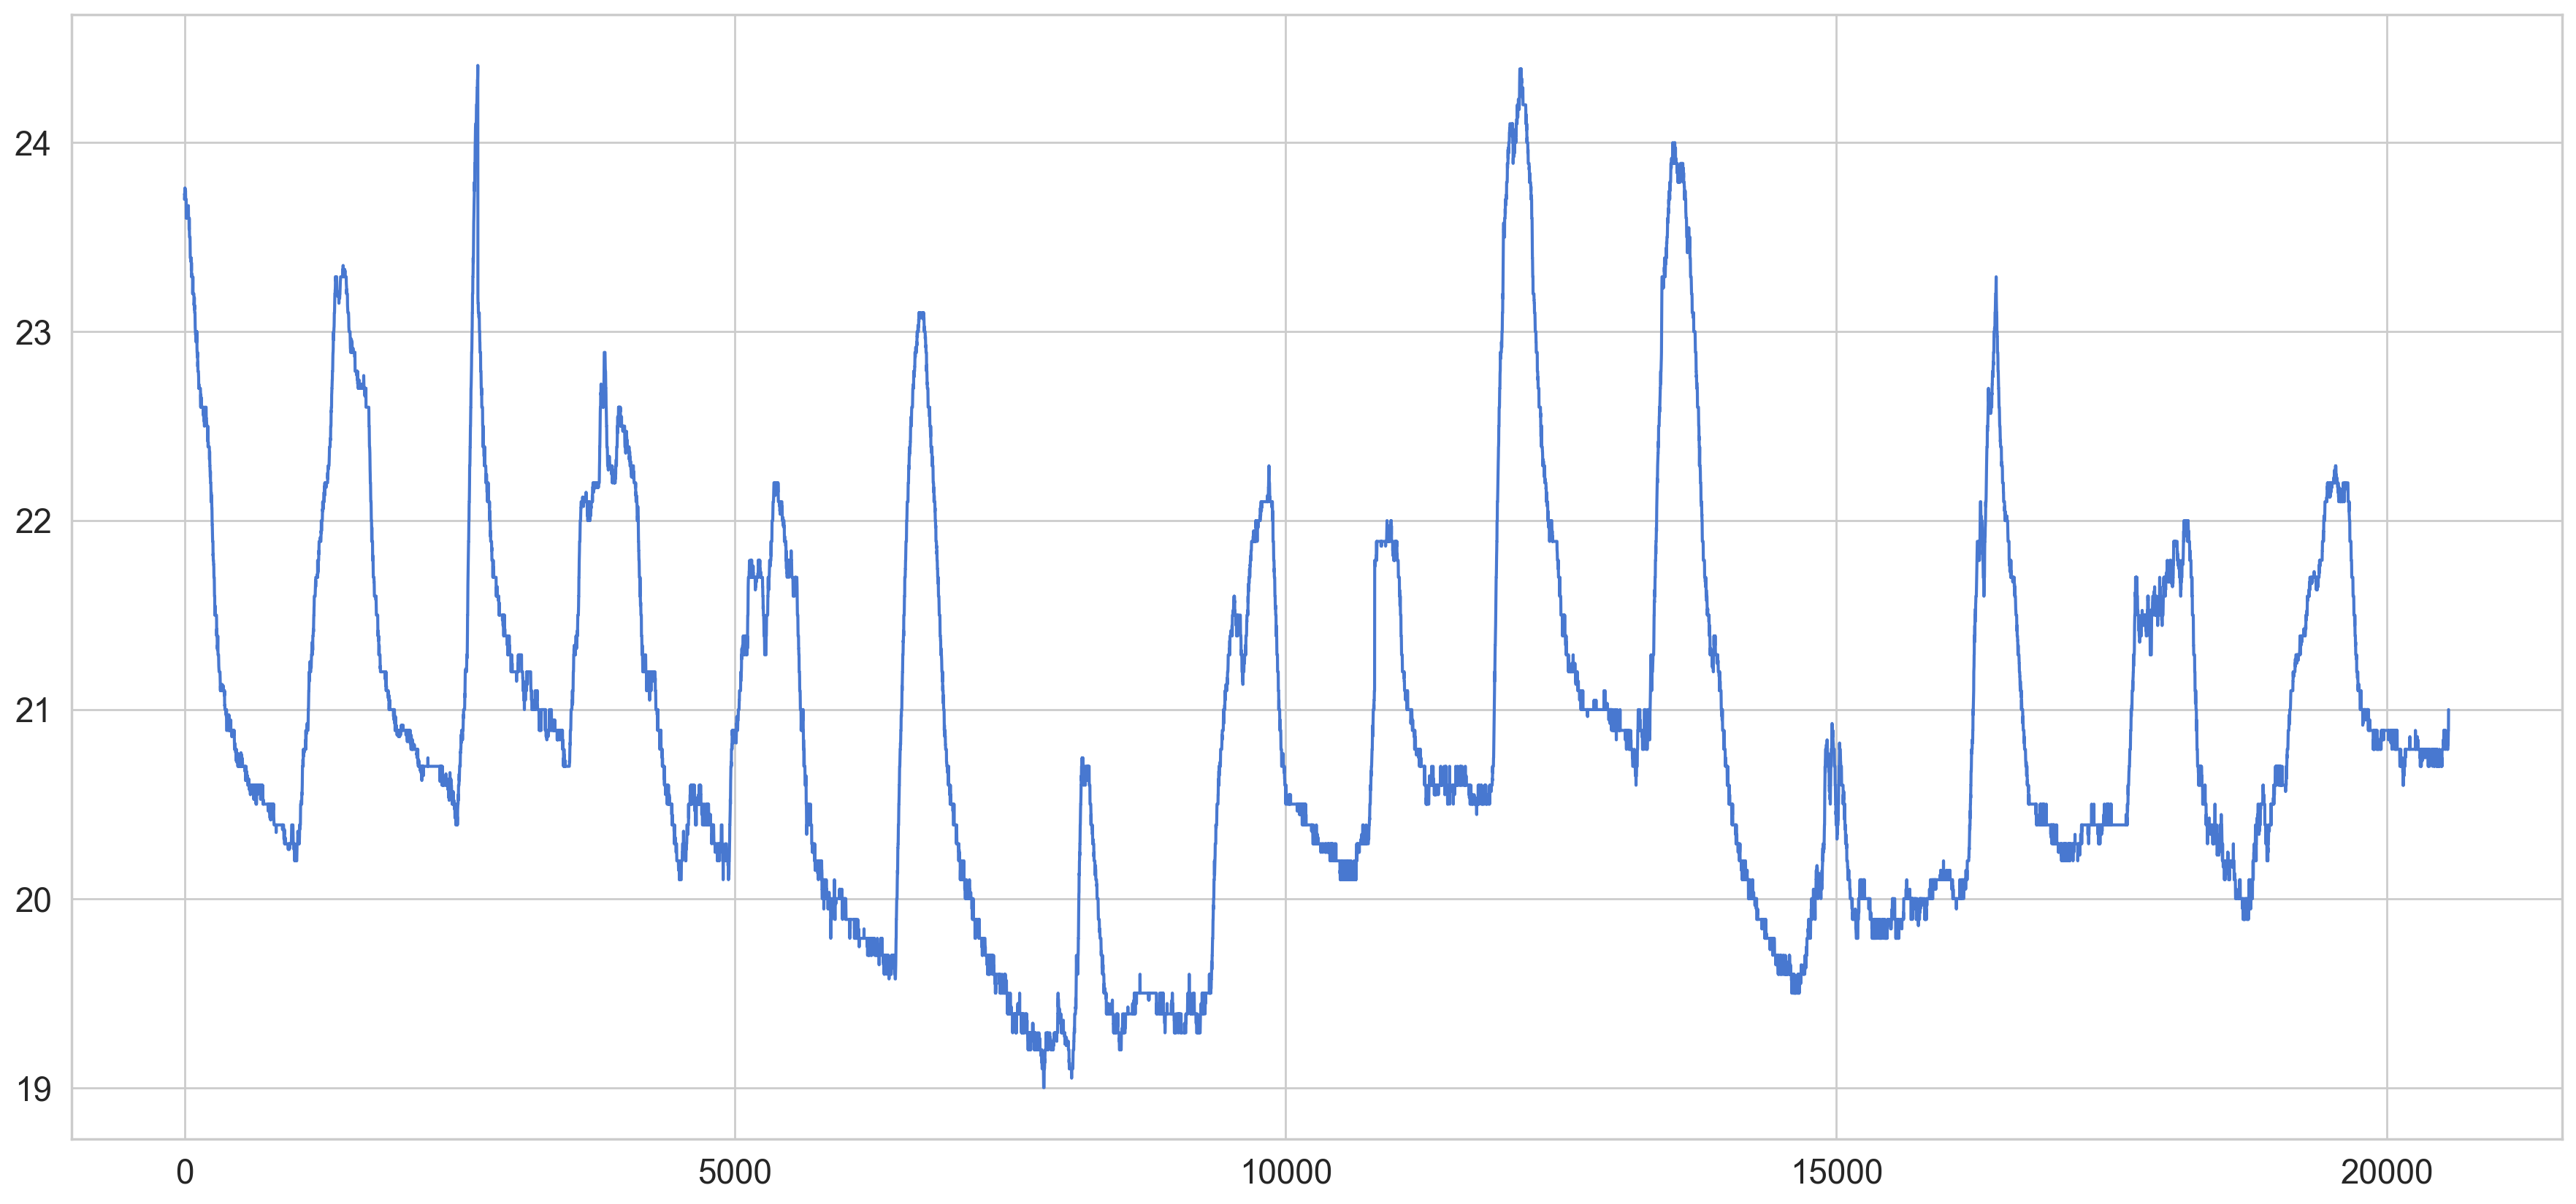

In [142]:
df = df[['date', 'Temperature']]

pd.options.mode.chained_assignment = None
df['date'] = pd.to_datetime(df['date'])

df['hour'] = df.apply(lambda x: x['date'].hour,axis=1)
df['dayofweek'] = df.apply(lambda x: x['date'].dayofweek,axis=1)
df['month'] = df.apply(lambda x: x['date'].month,axis=1)
df['dayofyear'] = df.apply(lambda x: x['date'].dayofyear,axis=1)
df = df.sort_values('date').drop('date',axis=1)

print(df)
sns.lineplot(x=range(len(df)), y=df['Temperature'])

In [143]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(16448, 5) (4112, 5)


In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Temperature']])

train['Temperature'] = scaler.transform(train[['Temperature']])
test['Temperature'] = scaler.transform(test[['Temperature']])

In [145]:
def create_dataset(X, y, time_steps=1):
  x_values = []
  y_values = []

  for i in range(len(X) - time_steps):
    x_values.append(X.iloc[i:(i+time_steps)].values)
    y_values.append(y.iloc[i+time_steps])

  return np.array(x_values), np.array(y_values)

In [146]:
time_steps = 30 # number of time steps to look back

X_train, y_train = create_dataset(train[['Temperature']], train['Temperature'], timeteps)
X_test, y_test = create_dataset(test[['Temperature']], test['Temperature'], time_steps)

print(X_train.shape)

(16418, 30, 1)


In [154]:
model = keras.Sequential()

# encoder
model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.1))

#decoder
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')
model.summary()

AttributeError: Exception encountered when calling layer "lstm_12" (type LSTM).

module 'tensorflow.python.platform.build_info' has no attribute 'build_info'

Call arguments received by layer "lstm_12" (type LSTM):
  • inputs=tf.Tensor(shape=(None, 30, 1), dtype=float32)
  • mask=None
  • training=None
  • initial_state=None

In [ ]:
history = model.fit(
  X_train, y_train,
  epochs=10,
  batch_size=32,
  validation_split=0.1,
  shuffle=False
)

In [ ]:
y_predict = model.predict(X_test)
y_predict.reshape(-1, 30)
y_predict.shape

model.evaluate(X_test, y_test)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [ ]:
plt.title('Loss Distribution - Train', fontsize=16)
sns.distplot(train_mae_loss, bins=100, kde=True)

In [ ]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [ ]:
plt.title('Loss Distribution - Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True)